# Gradient Boosting Ordinal Regression: The `gbor` Python package

`gbor` is the Python implementation of a novel mathematical framework for adapting machine learning (ML) models to handle ordinal response variables. Our approach is inspired by functional gradient descent used in gradient boosting and can be viewed as an extension of coordinate descent, where an ML regression model is embedded within a standard ordinal regression framework (e.g., logit or probit). The training process involves alternating between refining the ML model to predict a latent variable and adjusting the threshold vector applied to this latent variable to produce the ordinal response.

The workhorse is the `BoostedOrdinal` class, which conforms to `scikit-learn` conventions, including implementation of `fit`, `predict` and `predict_proba` methods. This allows for easy wrapping of the learner in hyperparameter tuning facilities provided in scikit-learn such as `GridSearch`.

## Data

In this tutorial, we illustrate the use of `gbor` package using the *wine quality* dataset, which can be downloaded from the [UCI ML repository](https://archive.ics.uci.edu/dataset/186/wine+quality):.


In [1]:
import pandas as pd
wine_red = pd.read_csv('../data/winequality-red.csv', sep = ';')
wine_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We will use the `quality` column as ordinal response variable, which contains levels 3 through 8. We will use the remaining columns of the data as features.

In [2]:
wine_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Before applying performing ordinal regression, we must convert the ordinal column to standard format expected by the `BoostedOrdinal` learner, i.e., class labels must take integer values between $0$ and $M-1$, with $M$ being the number of classes:

In [3]:
wine_red['quality'] = wine_red['quality'] - 3
wine_red['quality'].describe()

count    1599.000000
mean        2.636023
std         0.807569
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: quality, dtype: float64

Let's create a histogram of the response variable to inspect class imbalance:

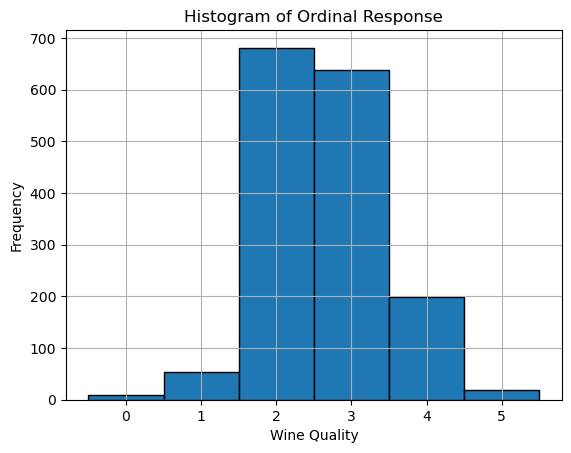

Distribution of ordinal response:


(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([ 10,  53, 681, 638, 199,  18], dtype=int64))

In [20]:
import matplotlib.pyplot as plt

wine_red['quality'].hist(edgecolor = 'black', align = 'mid', bins = [i - 0.5 for i in range(7)])
plt.xlabel('Wine Quality')
plt.ylabel('Frequency')
plt.title('Histogram of Ordinal Response')

plt.show()

import numpy as np

print('Distribution of ordinal response:')
np.unique(wine_red['quality'], return_counts = True)

Before proceeding with ordinal regression models, we extract the feature matrix and response vector, and also split the data into train/test sets:

In [50]:
from sklearn.model_selection import train_test_split

X, y = wine_red.drop(columns = ['quality']).to_numpy(), wine_red['quality'].to_numpy(dtype = 'int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

## Ordered Logit

We use the `mord` package for training an ordered logit model (add a brief description of the model linearity in this context), and calculate the classification error as well Manhattan distance. While classification error is insensitive to the distance between predicted and actual classes, Manhattan distance reflects this distance, which is rather sensible given that we are dealing with an ordinal response.

We also set `alpha` to zero to bypass any regularization since we have a decent ratio of observations:

In [51]:
from mord import LogisticIT
mord_model = LogisticIT(alpha = 0.0)
mord_model.fit(X_train, y_train)
y_pred_mord = mord_model.predict(X_test)

mord_classification_error, mord_manhattan_error = np.mean(y_test - y_pred_mord != 0), np.mean(abs(y_test - y_pred_mord))
print('Observation/feature ratio:', int(X_train.shape[0] / X_train.shape[1]))
print('Ordered logit - classification error:', mord_classification_error)
print('Ordered logit - Manhattan error:', mord_manhattan_error)

Observation/feature ratio: 87
Ordered logit - classification error: 0.4296875
Ordered logit - Manhattan error: 0.4671875


## Gradient Boosting Ordinal Regression (GBOR)

We now use the `gbor` package to train an ML ordinal regression model. We use a decision tree regressor as base learner, and also turn on early stopping via the `n_iter_no_change` parameter:

In [52]:
from gbor.main import BoostedOrdinal
from sklearn.tree import DecisionTreeRegressor

gbor_model = BoostedOrdinal(n_iter_no_change = 10, max_iter = 1000, base_learner = DecisionTreeRegressor(max_depth = 6)).fit(X_train, y_train)
y_pred_gbor = gbor_model.predict(X_test)

gbor_classification_error, gbor_manhattan_error = np.mean(y_test - y_pred_gbor != 0), np.mean(abs(y_test - y_pred_gbor))
print('GBOR - classification error:', gbor_classification_error)
print('GBOR - Manhattan error:', gbor_manhattan_error)

GBOR - classification error: 0.403125
GBOR - Manhattan error: 0.440625


We see that `gbor` outeprforms `mord` by 2-3 percentage points on both metrics.

## Hyperparameter Tuning for GBOR

Any ML model has hyperparameters which can be tuned to improve predictive performance. GBOR is no exception. These hyperparameters include those of the base learner, as well as a few parameters that govern the GBOR meta-algorithm, including:
1. `lr_g`: Learning rate for the gradient boosting step
2. `lr_theta`: Learning rate for the threshold adjustment step
3. `max_iter`: Maximum allowed number of boosting iterations

The default base learner in `BoostedOrdinal` is the `DecisionTreeRegressor` from `sklearn` package. For a full list of its hyperparameters, see the official site [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

While an exhaustive discussion of hyperparameter tuning is beyond the scope of this tutorial, we illustrate how `sklearn`'s HPT facilities can be used with `BoostedOrdinal` to automate the HPT process and create a composite learner that is plug-and-play. We begin with the grid search HPT strategy.

### Grid Search

The `GridSearchCV` from `sklearn` allows us to wrap a learner in a cross-validation based grid search strategy. This approach requires the user to supply a hyperparameter grid for search. In creating the grid, we can refer to the base-learner HP's via the prefix `base_learner__`. We can also override the default HP's of the learner while instantiating a `BoostedOrdinal` instance, which will be cloned in the grid search wrapper. As long as these overridden values don't clash with the HP's being tuned, we are ok:

In [61]:
from sklearn.model_selection import GridSearchCV

bor = BoostedOrdinal(n_iter_no_change = 10, max_iter = 1000, validation_fraction = 0.2)
parameter_grid = {'base_learner__max_depth': [3, 6, 9], 'lr_g': [1e-1, 1e-2, 1e-3]}

As seen above, we are setting up a 3x3 grid using the `max_depth` HP for the decision tree, and the learning rate for the gradient boosting step. Each are arugably the most critical HP's in their respective categories. We now define the `GridSearchCV` composite learner, overriding the `scoring` metric (default is accuracy for classifiers) with negative log loss, which requires having implemented a `predict_proba` function for the `BoostedOrdinal` class.

In [62]:
gscv_model = GridSearchCV(
    bor, parameter_grid
    , scoring = 'neg_log_loss'
)

We can now `fit` this composite learner like any other learner. The HPT grid search is now internal to the learner, and we automatically get the best (i.e., tuned) learner back for prediction:

In [63]:
gscv_model.fit(X_train, y_train)

GridSearchCV(estimator=BoostedOrdinal(max_iter=1000, n_iter_no_change=10,
                                      validation_fraction=0.2),
             param_grid={'base_learner__max_depth': [3, 6, 9],
                         'lr_g': [0.1, 0.01, 0.001]},
             scoring='neg_log_loss')

We can examine the best model to see the HP's selected during grid search:

In [64]:
print('decision tree - max depth:', gscv_model.best_estimator_.base_learner.max_depth)
print('gradient boosting - learning rate:', gscv_model.best_estimator_.lr_g)

decision tree - max depth: 6
gradient boosting - learning rate: 0.1


Let's calculate the same error metrics for this model:

In [65]:
y_pred_gscv = gscv_model.predict(X_test)

gscv_classification_error, gscv_manhattan_error = np.mean(y_test - y_pred_gscv != 0), np.mean(abs(y_test - y_pred_gscv))
print('GBOR + grid seach - classification error:', gscv_classification_error)
print('GBOR + grid search - Manhattan error:', gscv_manhattan_error)

GBOR + grid seach - classification error: 0.40625
GBOR + grid search - Manhattan error: 0.4390625


Note that training the model now takes significantly longer, despite a relatively coarse grid that we introduced. Adding more resolution, and more dimensions, to the grid will increase the training time, but also will likely result in better performance of the final model.

### Random Search

As argued in Bergstra and Bengio (2012), random search is more efficient than grid search in HPT. We can access this strategy in `sklearn` using the `RandomizedSearchCV` class. Here, instead of a grid we must provide a set of distributions for the strategy to draw each of the HP's from.

In [75]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

parameter_distros = {
    'base_learner__max_depth': [3, 4, 5, 6, 7, 8, 9]
    , 'lr_g': loguniform(1e-3, 1e-1)
}

rscv_model = RandomizedSearchCV(
    bor, parameter_distros
    , scoring = 'neg_log_loss'
    , n_iter = 50
)

rscv_model.fit(X_train, y_train)

RandomizedSearchCV(estimator=BoostedOrdinal(max_iter=1000, n_iter_no_change=10,
                                            validation_fraction=0.2),
                   n_iter=50,
                   param_distributions={'base_learner__max_depth': [3, 4, 5, 6,
                                                                    7, 8, 9],
                                        'lr_g': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000205BE5D5490>},
                   scoring='neg_log_loss')

Let's examine the best parameters:

In [76]:
rscv_model.best_params_

{'base_learner__max_depth': 4, 'lr_g': 0.03286157961173112}

Let's also examine the performance:

In [77]:
y_pred_rscv = rscv_model.predict(X_test)

rscv_classification_error, rscv_manhattan_error = np.mean(y_test - y_pred_rscv != 0), np.mean(abs(y_test - y_pred_rscv))
print('GBOR + random seach - classification error:', rscv_classification_error)
print('GBOR + random search - Manhattan error:', rscv_manhattan_error)

GBOR + random seach - classification error: 0.43125
GBOR + random search - Manhattan error: 0.46875


A more systematic approach for comparing performance of models and HPT strategies is to use cross-validation (or even repeated cross-validation) to cover the utilize the entire data, rather than a fixed train/test split, which is not as reliable. We leave this exercise to the reader.

## References
1. Bergstra, James, and Yoshua Bengio. "Random search for hyper-parameter optimization." Journal of machine learning research 13.2 (2012).